In [38]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np


from gala.units import UnitSystem
import time

import jax
import jax.numpy as jnp

#from jax.config import config
jax.config.update("jax_enable_x64", True)



import jax.random as random 
from matplotlib.patches import Ellipse
import jax.scipy.stats as statsjax

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent, DirectAdjoint, RecursiveCheckpointAdjoint
import JaxStreams_Information as JaxStreams 

from jax.scipy.stats import gaussian_kde
import tqdm

In [39]:
#print(jax.devices())
#make sure to use not the first gpu, this choses the second
jax.default_device('CudaDevice(id=3)')

# The possibly atypical package dependencies:
- Jax [gpu] installation: https://jax.readthedocs.io/en/latest/installation.html
    - I am using v11 (not 12), so would recomend that version for now
- diffrax https://docs.kidger.site/diffrax/

I predict that there might be some version control issues. I.e., we should probably use consistent versions of numpy, astropy, jax, diffrax, and gala. So definetely make a safe environment where these can be adjusted.

In [40]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


/tmp/ipykernel_638376/1991717721.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


In [41]:
#helper function for nfw
@jax.jit
def get_nfw_rho0(M,r_s):
    c_NFW = 15. # following https://arxiv.org/pdf/2211.04495
    denom = jnp.log(1. + c_NFW) - (c_NFW/(1+c_NFW))
    fac = 1./denom
    rho0 = (M/(4*jnp.pi*r_s**3))*fac
    return rho0
np.log10(get_nfw_rho0(3e12,22.))

7.086986282014672

In [42]:
#interpolated NWF potential, solves poisson used in all orbit integrations
interp_func = jnp.load('general_nfw_interp.npy',allow_pickle=True).item()

In [43]:

@jax.jit
def gen_prog_orbit(x_prog, y_prog, z_prog, f_circ, v_x_hat, v_y_hat, pm, log10_m_disk, a_disk,
              b_disk, log10_m_halo, r_s, gamma, beta):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    f_circ is fraction of location circular velocity at location today
    v_xy hat is unit velocity vector components along x (proper motion direction) and v_y (LOS direction, rv)
    max of v_x_hat and v_y_hat is \pm 1/sqrt(2) [1 - 2x^2 = 0]
    pm is either +1 or -1 for going up or going down (along +/- z) in sky plane
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':7_000.}
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
                                     gamma=params['gamma'], beta=params['beta'], interp_func=interp_func,
                                              units=usys)

    
    potential_list = [pot_disk,pot_halo]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


    v_z_hat = jnp.sqrt(1.0 - v_x_hat**2 - v_y_hat**2)*pm
    pos_today = jnp.array([x_prog, y_prog, z_prog])
    circular_vel = pot.local_circular_velocity(pos_today,0.0) #275.0*(u.km/u.s).to(u.kpc/u.Myr)#
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*circular_vel*f_circ
    w_today = jnp.hstack([pos_today, velocity_today])
    
    w_init = pot.orbit_integrator_run_notdense_PID(w_today,0.0, -params['t_age'],None,None)[0]
    ts = jnp.linspace(-params_global_potential['t_age'],0,4_000) #4_000
    orb = pot.orbit_integrator_run_notdense_PID(w_init,ts.min(), ts.max(),ts,None)[:-1,:]
    return ts, orb

def gen_orbit_from_dict(dictionary):
    return gen_prog_orbit(dictionary['x_prog'], dictionary['y_prog'], dictionary['z_prog'],
                     dictionary['f_circ'], dictionary['v_x_hat'], dictionary['v_y_hat'],
                     dictionary['pm'], dictionary['log10_m_disk'], dictionary['a_disk'],
                     dictionary['b_disk'], dictionary['log10_m_halo'], dictionary['r_s'], dictionary['gamma'], dictionary['beta'],
                         dictionary['t_age'])
    
# Genstream: supply on ksy pos of progenitor, everything about progentior, location, velocity vectors
# also depends on potentail model, age of straam (since it started stripping), narm: how many particles
# in each stream.    
@partial(jax.jit,static_argnums=(14,15))
def gen_stream(x_prog, y_prog, z_prog, f_circ, v_x_hat, v_y_hat, pm, log10_m_disk, a_disk,
              b_disk, log10_m_halo, r_s, gamma, beta, t_age, N_arm):
    """
    x and z is sky plane, y is LOS
    xyz_prog is the progenitor position today in these coords
    f_circ is fraction of location circular velocity at location today
    v_xy hat is unit velocity vector components along x (proper motion direction) and v_y (LOS direction, rv)
    max of v_x_hat and v_y_hat is \pm 1/sqrt(2) [1 - 2x^2 = 0]
    pm is either +1 or -1 for going up or going down (along +/- z) in sky plane
    """
    params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
                          'r_s': r_s, 'gamma': gamma, 'beta':beta, 't_age':t_age}
    #here's where the potentials are defined
    #JaxStreams: can add your own potential
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                       b=params['b_disk'],units=usys)
    rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
    pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
                                     gamma=params['gamma'], beta=params['beta'],interp_func=interp_func,
                                              units=usys)
    
    #combine potentials while putting them in list. 
    potential_list = [pot_disk,pot_halo]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)

    #integrate orbit in this framework...
    #
    v_z_hat = jnp.sqrt(1.0 - v_x_hat**2 - v_y_hat**2)*pm
    pos_today = jnp.array([x_prog, y_prog, z_prog])
    circular_vel = pot.local_circular_velocity(pos_today,0.0) #275.0*(u.km/u.s).to(u.kpc/u.Myr)#
    velocity_today = jnp.array([v_x_hat, v_y_hat, v_z_hat])*circular_vel*f_circ
    w_today = jnp.hstack([pos_today, velocity_today])
    # below is how you integrate orbit
    w_init = pot.orbit_integrator_run_notdense_PID(w_today,0.0, -t_age,None,None)[0]

    
    ## Now generate a mock stream along the above orbit
    M_sat = 5e7 #progenitor mass
    seed = 4031
    ts = jnp.linspace(-t_age,0,N_arm) #4_000
    #this is how you generate a stream 
    lead_arm, trail_arm = pot.gen_stream_vmapped_notdense_PID(ts, w_init, M_sat,seed,None)
    stream = jnp.vstack([lead_arm[:,0,:],trail_arm[:,0,:]])
    return w_today, stream, jnp.hstack([ts, ts])

#for nautilus to work we need it all in dictionaries 
def gen_stream_from_dict(dictionary):
    return gen_stream(dictionary['x_prog'], dictionary['y_prog'], dictionary['z_prog'],
                     dictionary['f_circ'], dictionary['v_x_hat'], dictionary['v_y_hat'],
                     dictionary['pm'], dictionary['log10_m_disk'], dictionary['a_disk'],
                     dictionary['b_disk'], dictionary['log10_m_halo'], dictionary['r_s'], dictionary['gamma'],
                    dictionary['beta'], dictionary['t_age'], N_arm=dictionary['N_arm'])


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_638376/3735787395.py:4: SyntaxWarning: invalid escape sequence '\p'
  """
/tmp/ipykernel_638376/3735787395.py:51: SyntaxWarning: invalid escape sequence '\p'
  """


In [44]:
inner_stream_prog0 = dict(x_prog=60.0,y_prog=40.0,z_prog=40.0,f_circ=.6,v_x_hat=.6, v_y_hat=.5,pm=-1.0,
                         log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,gamma=1.,beta=3.,
                         t_age=7000., N_arm=4_000) #4_000

outer_stream_prog0 = dict(x_prog=-100.0,y_prog=200.0,z_prog=200.0,f_circ=1.25,v_x_hat=.7, v_y_hat=-.3,pm=1.0, 
                     log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,gamma=1,beta=3.,
                         t_age=7000., N_arm=4_000) #4_000

#make the two streams from specified progenitors above 
wtoday, inner_stream_NFW, stripping_times = gen_stream_from_dict(inner_stream_prog0)
outer_stream_NFW = gen_stream_from_dict(outer_stream_prog0)[1]

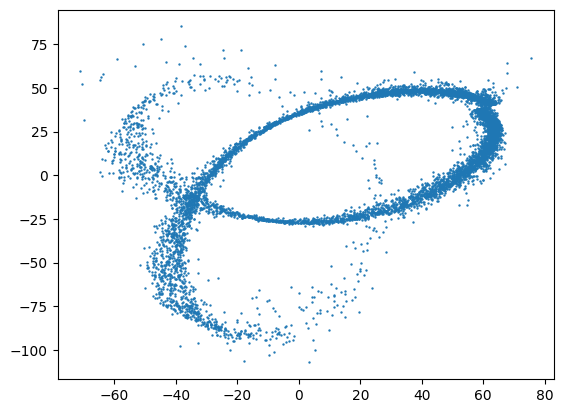

In [45]:
plt.scatter(inner_stream_NFW[:,0],inner_stream_NFW[:,2],s=.5)
plt.scatter(outer_stream_NFW[:,0],outer_stream_NFW[:,2],s=.5)

#plt.xlim(-60,60)
#plt.ylim(-100,90)

In [46]:
#from data make histogram of stream
#thresh: how many particles need to be in the bin 

def gen_stream_hist(stream_dim1,stream_dim2,thresh,xlin,zlin):
    """On sky x an z, xlin, zlin defines bin in each dimension"""
    H  = jnp.histogram2d(stream_dim1,stream_dim2,bins=(xlin,zlin))
    hist2d = H[0]
    #only keep things above the threshold
    masked_hist = jnp.where(hist2d>thresh,1.0,0.0)
    xinds, zinds = jnp.where(masked_hist == 1.)
    
    #even if only one star in a bin, wherever hist2 is grater than threshold, then use that
    # value otherwise zero and then normalize it 
    weights_of_pts = jnp.where(hist2d>thresh,hist2d,0.0)
    weights_of_pts = weights_of_pts/weights_of_pts.sum()
    
    #dx_over_2 = (xlin[2] - xlin[1])/2
    #dz_over_2 =  (zlin[2] - zlin[1])/2
    # Compute bin centers along both axes
    x_centers = 0.5 * (xlin[:-1] + xlin[1:])
    z_centers = 0.5 * (zlin[:-1] + zlin[1:])
    
    #spits out histogram (nxn grid dim of zlin zlin, value of histogram, midpoints)
    #indexed so also get coordinates of histogram points
    return masked_hist.T, weights_of_pts[xinds,zinds], x_centers[xinds], z_centers[zinds]#xlin[xinds] + dx_over_2, zlin[zinds] + dz_over_2
    
xlin_inner = jnp.linspace(-100,100,50)
zlin_inner = jnp.linspace(-110,80,51)
#for image you would just choose control poibts 
#for imaging wouldn't have the histogram step, just step of points (red)
#for image data just select out pixels where you are above a threshold, don't need histogram step
#the red are the datapoints we evaluate over
H_inner, weights_inner, xpts_inner, zpts_inner = gen_stream_hist(inner_stream_NFW[:,0],inner_stream_NFW[:,2],3,xlin_inner,zlin_inner)


xlin_outer = jnp.linspace(-350,300,70)
zlin_outer = jnp.linspace(-200,350,71)
H_outer, weights_outer, xpts_outer, zpts_outer = gen_stream_hist(outer_stream_NFW[:,0],outer_stream_NFW[:,2],4,xlin_outer,zlin_outer)


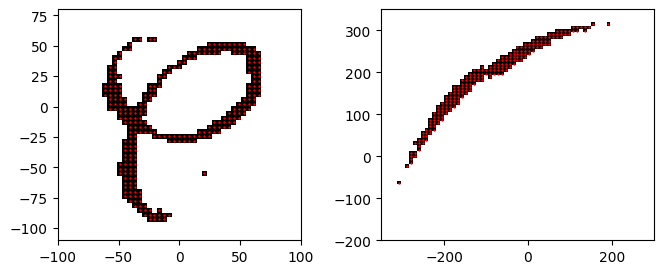

In [47]:
dat_inner = jnp.vstack([xpts_inner, zpts_inner]).T
dat_outer = jnp.vstack([xpts_outer, zpts_outer]).T

fig, ax = plt.subplots(1,2)
fig.set_size_inches(5,5)
fig.set_size_inches(8,3)
ax[0].pcolormesh(xlin_inner,zlin_inner,H_inner,cmap='binary')
ax[0].scatter(dat_inner[:,0],dat_inner[:,1],color='r',s=.5)

ax[1].pcolormesh(xlin_outer,zlin_outer,H_outer,cmap='binary')
ax[1].scatter(dat_outer[:,0],dat_outer[:,1],color='r',s=.5)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

#red poitns here, is what the method actually needs 



In [48]:
#these functions are not used but:
# if you pick random pixel,m what is the probability that it contains a stream? 
#same prior probabily along all points on the stream (1/n red points), 0 if not on the stream
@jax.jit
def p_data_inner(x,z, dat=dat_inner):
    """
    If x and z (tuple) are in dat, then return 1/len(dat). Otherwise return 0
    """
    return jnp.any(jnp.all(dat == jnp.array([x, z]), axis=1,)).sum()/len(dat) 


@jax.jit
def p_data_outer(x,z, dat=dat_outer):
    """
    If x and z (tuple) are in dat, then return 1/len(dat). Otherwise return 0
    """
    return jnp.any(jnp.all(dat == jnp.array([x, z]), axis=1,)).sum()/len(dat) 
    

In [49]:
p_data_inner(dat_inner[10,0],dat_inner[10,1])

Array(0.00361011, dtype=float64)

In [50]:
p_data_outer(dat_outer[10,0],dat_outer[10,1])

Array(0.00507614, dtype=float64)

In [51]:
# generated a mock stream, give this functon x and z of that, then give evaluation points (red ones)
# ts was used in weighing before
# now instead we just fit stream with kde and take 1 over the weight KDE and that's the one you keep 
@jax.jit
def log_pdf_model(x_stream, z_stream, x_eval, z_eval, ts):
    inp = jnp.vstack([x_stream, z_stream])
    inp_eval = jnp.vstack([x_eval, z_eval])
    ts = jnp.abs(ts)
    ts = (ts - ts.min())/(ts.max()-ts.min())
    return gaussian_kde(inp,bw_method=.1,weights=ts).logpdf(inp_eval)

#not all are free parameters, some ara params and some are fixed
# x, z coords, since we know position of sky
# what ever is said fixed is fixed here. 
@jax.jit
def gen_stream_from_params(params, params_fix):
    stream_dict = dict(x_prog=params_fix['x_prog'],y_prog=params['y_prog'],
                       z_prog=params_fix['z_prog'],f_circ=params['f_circ'],v_x_hat=params['v_x_hat'],
                       v_y_hat=params['v_y_hat'],
                       log10_m_disk=params_fix['log10_m_disk'], 
                       a_disk=params_fix['a_disk'],b_disk=params_fix['b_disk'],
                       log10_m_halo=params['log10_m_halo'],r_s=params['r_s'],
                       gamma=params['gamma'],beta=params['beta'],t_age=params['t_age'],
                       N_arm=500, pm=params_fix['pm'])
    w_today, trial_stream, ts = gen_stream_from_dict(stream_dict)
    return trial_stream, ts

#x_dat z_dat are red points from before
@jax.jit
def evaluate_cost_no_prior(params, params_fix, x_dat, z_dat):
    """
    Disregard... params is a dictionary but this shows what goes into it:
    params[0]: y_prog
    params[1]: f_circ
    params[2]: v_x_hat
    params[3]: v_y_hat
    params[4]: log10_m_halo
    params[5]: r_s
    params[6]: gamma
    params[7]: beta
    params[8]: t_age
    """
    #generates trial streams to test if they are close to data 
    trial_stream, ts  = gen_stream_from_params(params, params_fix)
    #how close is model to data 
    log_pdf_Q = log_pdf_model(trial_stream[:,0], trial_stream[:,2], x_dat, z_dat, ts)
    inter_sum = (1./len(x_dat))*( jnp.log((1./len(x_dat))) - log_pdf_Q )
    neg_KL = -jnp.sum(inter_sum)
    return neg_KL ### maximizie this (it's just the evidence lower bound) where does this happen though?
    
#allows us to generate many streams in one go - jax feature     
@jax.jit    
def vectorized_cost(params,params_fix, x_dat, z_dat):
    mapped_func = jax.vmap(evaluate_cost_no_prior,in_axes=({'y_prog':0, 'f_circ':0,
                                             'v_x_hat':0, 'v_y_hat':0,
                                             'log10_m_halo':0, 'r_s':0,
                                             'gamma':0, 'beta':0,
                                             't_age':0}, None,None,None))
    return mapped_func(params, params_fix, x_dat, z_dat)



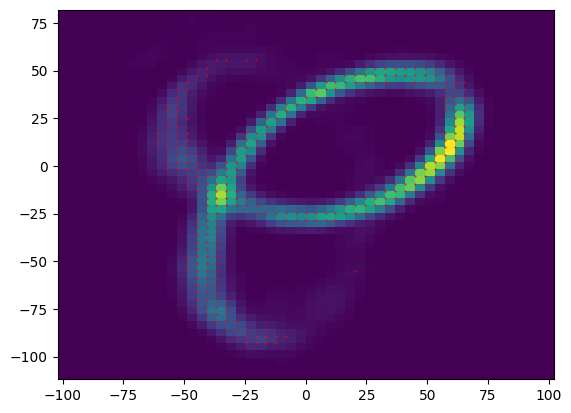

In [52]:
inp = jnp.vstack([inner_stream_NFW[:,0], inner_stream_NFW[:,2]])
ts = jnp.abs(stripping_times)
ts = (ts - ts.min())/(ts.max()-ts.min())
#would not do the below with data, because I woduln't have it 
kde_test = gaussian_kde(inp,bw_method=.1, weights=ts)


X, Z = jnp.meshgrid(xlin_inner, zlin_inner)
inp_eval = jnp.vstack([X.flatten(),Z.flatten()])
#look at density weighted by stripping time 
# red points also capture width and length of stream didn't use this info in 22 paper 
pdf_out = kde_test.pdf(inp_eval)
fig, ax = plt.subplots(1,1)
ax.pcolormesh(X,Z, pdf_out.reshape(X.shape))

ax.scatter(dat_inner[:,0], dat_inner[:,1],s=.2,color='r')


In [53]:
dat_inner.shape

(277, 2)

In [54]:
#test to see if the correct fixed params recovers the corecrt gamma
# does the method work. 
@jax.jit
def test_bias_gamma(gamma):
    test_params = dict(y_prog=40.0, f_circ=.6,v_x_hat=.6, v_y_hat=.5,
                         log10_m_halo=13.0,r_s=22.0,gamma=gamma,beta=3.,
                         t_age=7000.)
    test_fix_params =  dict(x_prog=60.0, z_prog=40., pm=-1.,log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2)
    # test which gamma is preffered 
    #could have done any other param here than gamma. 
    #slizing likelighood 
    return evaluate_cost_no_prior(test_params, test_fix_params, dat_inner[:,0], dat_inner[:,1])


In [55]:
gamma_lin = jnp.linspace(0,2,20)
obj_out = jax.vmap(test_bias_gamma)(gamma_lin)

/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


KeyboardInterrupt: 

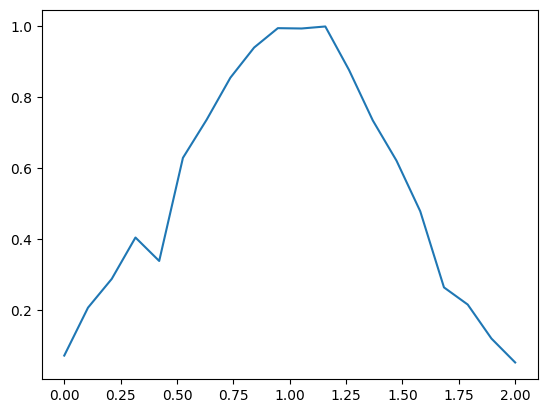

In [27]:
plt.plot(gamma_lin,np.exp(obj_out-obj_out.max()))

In [28]:
from nautilus import Prior
from nautilus import Sampler
#nested sampling

prior = Prior()
#specifing priors and naming paramters for nautilys t see
# everything is a top hat, lower and upper bound 
#could be flat, gaussian 
prior.add_parameter('y_prog', dist=(-80, 80.))
prior.add_parameter('f_circ', dist=(.45, 1.3))
prior.add_parameter('v_x_hat', dist=( -1/np.sqrt(2), 1./np.sqrt(2)))
prior.add_parameter('v_y_hat', dist=( -1/np.sqrt(2), 1./np.sqrt(2)))
prior.add_parameter('log10_m_halo', dist=( 12.5,13.5))
prior.add_parameter('r_s', dist=( 12.,30.))
prior.add_parameter('gamma', dist=( 0.,2.))
prior.add_parameter('beta', dist=( 2.,4.))
prior.add_parameter('t_age', dist=( 5_500.,8_500.))

params_fix_inner =  dict(x_prog=60.0, z_prog=40., pm=-1.,log10_m_disk=jnp.log10(5e10), a_disk=3.0,b_disk=0.2)

#nautilys likes to have only inpu to be free parmaeters (first argument)
#all the other arguments are cfixed 
cost_naut = lambda params: vectorized_cost(params,params_fix_inner, dat_inner[:,0], dat_inner[:,1])

In [1]:
#hours vs minutes below: nbatch how many streams do we generate for a single step of the sampler 
# ran 18000 streams while we had lunch
# nlive (all in nautulus documentation) making nlive lower, is afster, at the cost of accuracy 
# nautilus has recommendations: nested sampling... 
#nested smapling: puts down 2000 poiunts here, look for likelihood that is
# as you slize up. 
# nested sampling: if otyher peak: the slize will cut through both. Avoids jumoing from peak to oeak
sampler = Sampler(prior, cost_naut, n_live=1_000,vectorized=True,n_batch=500
                 )

NameError: name 'Sampler' is not defined

In [30]:
sampler.run(verbose=True, )


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    


/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/groups/astro/sapearso/miniforge3/envs/jax_test2/lib/python3.12/site-packages/jax/_src/core.py:701: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Finished  | 10     | 1        | 8        | 17500    | N/A    | 10397 | -7.18    


True

In [31]:
points, log_w, log_l = sampler.posterior(equal_weight=False)


In [32]:
dict_save = dict(points=points, log_w=log_w, log_l=log_l)
###jnp.save('inner_stream_samples_dict',dict_save)

In [33]:
true_params = jnp.array([inner_stream_prog0['y_prog'], 
                        inner_stream_prog0['f_circ'],
                        inner_stream_prog0['v_x_hat'],
                        inner_stream_prog0['v_y_hat'],
                        inner_stream_prog0['log10_m_halo'],
                        inner_stream_prog0['r_s'],
                        inner_stream_prog0['gamma'],
                         inner_stream_prog0['beta'],
                         inner_stream_prog0['t_age']
                        ])

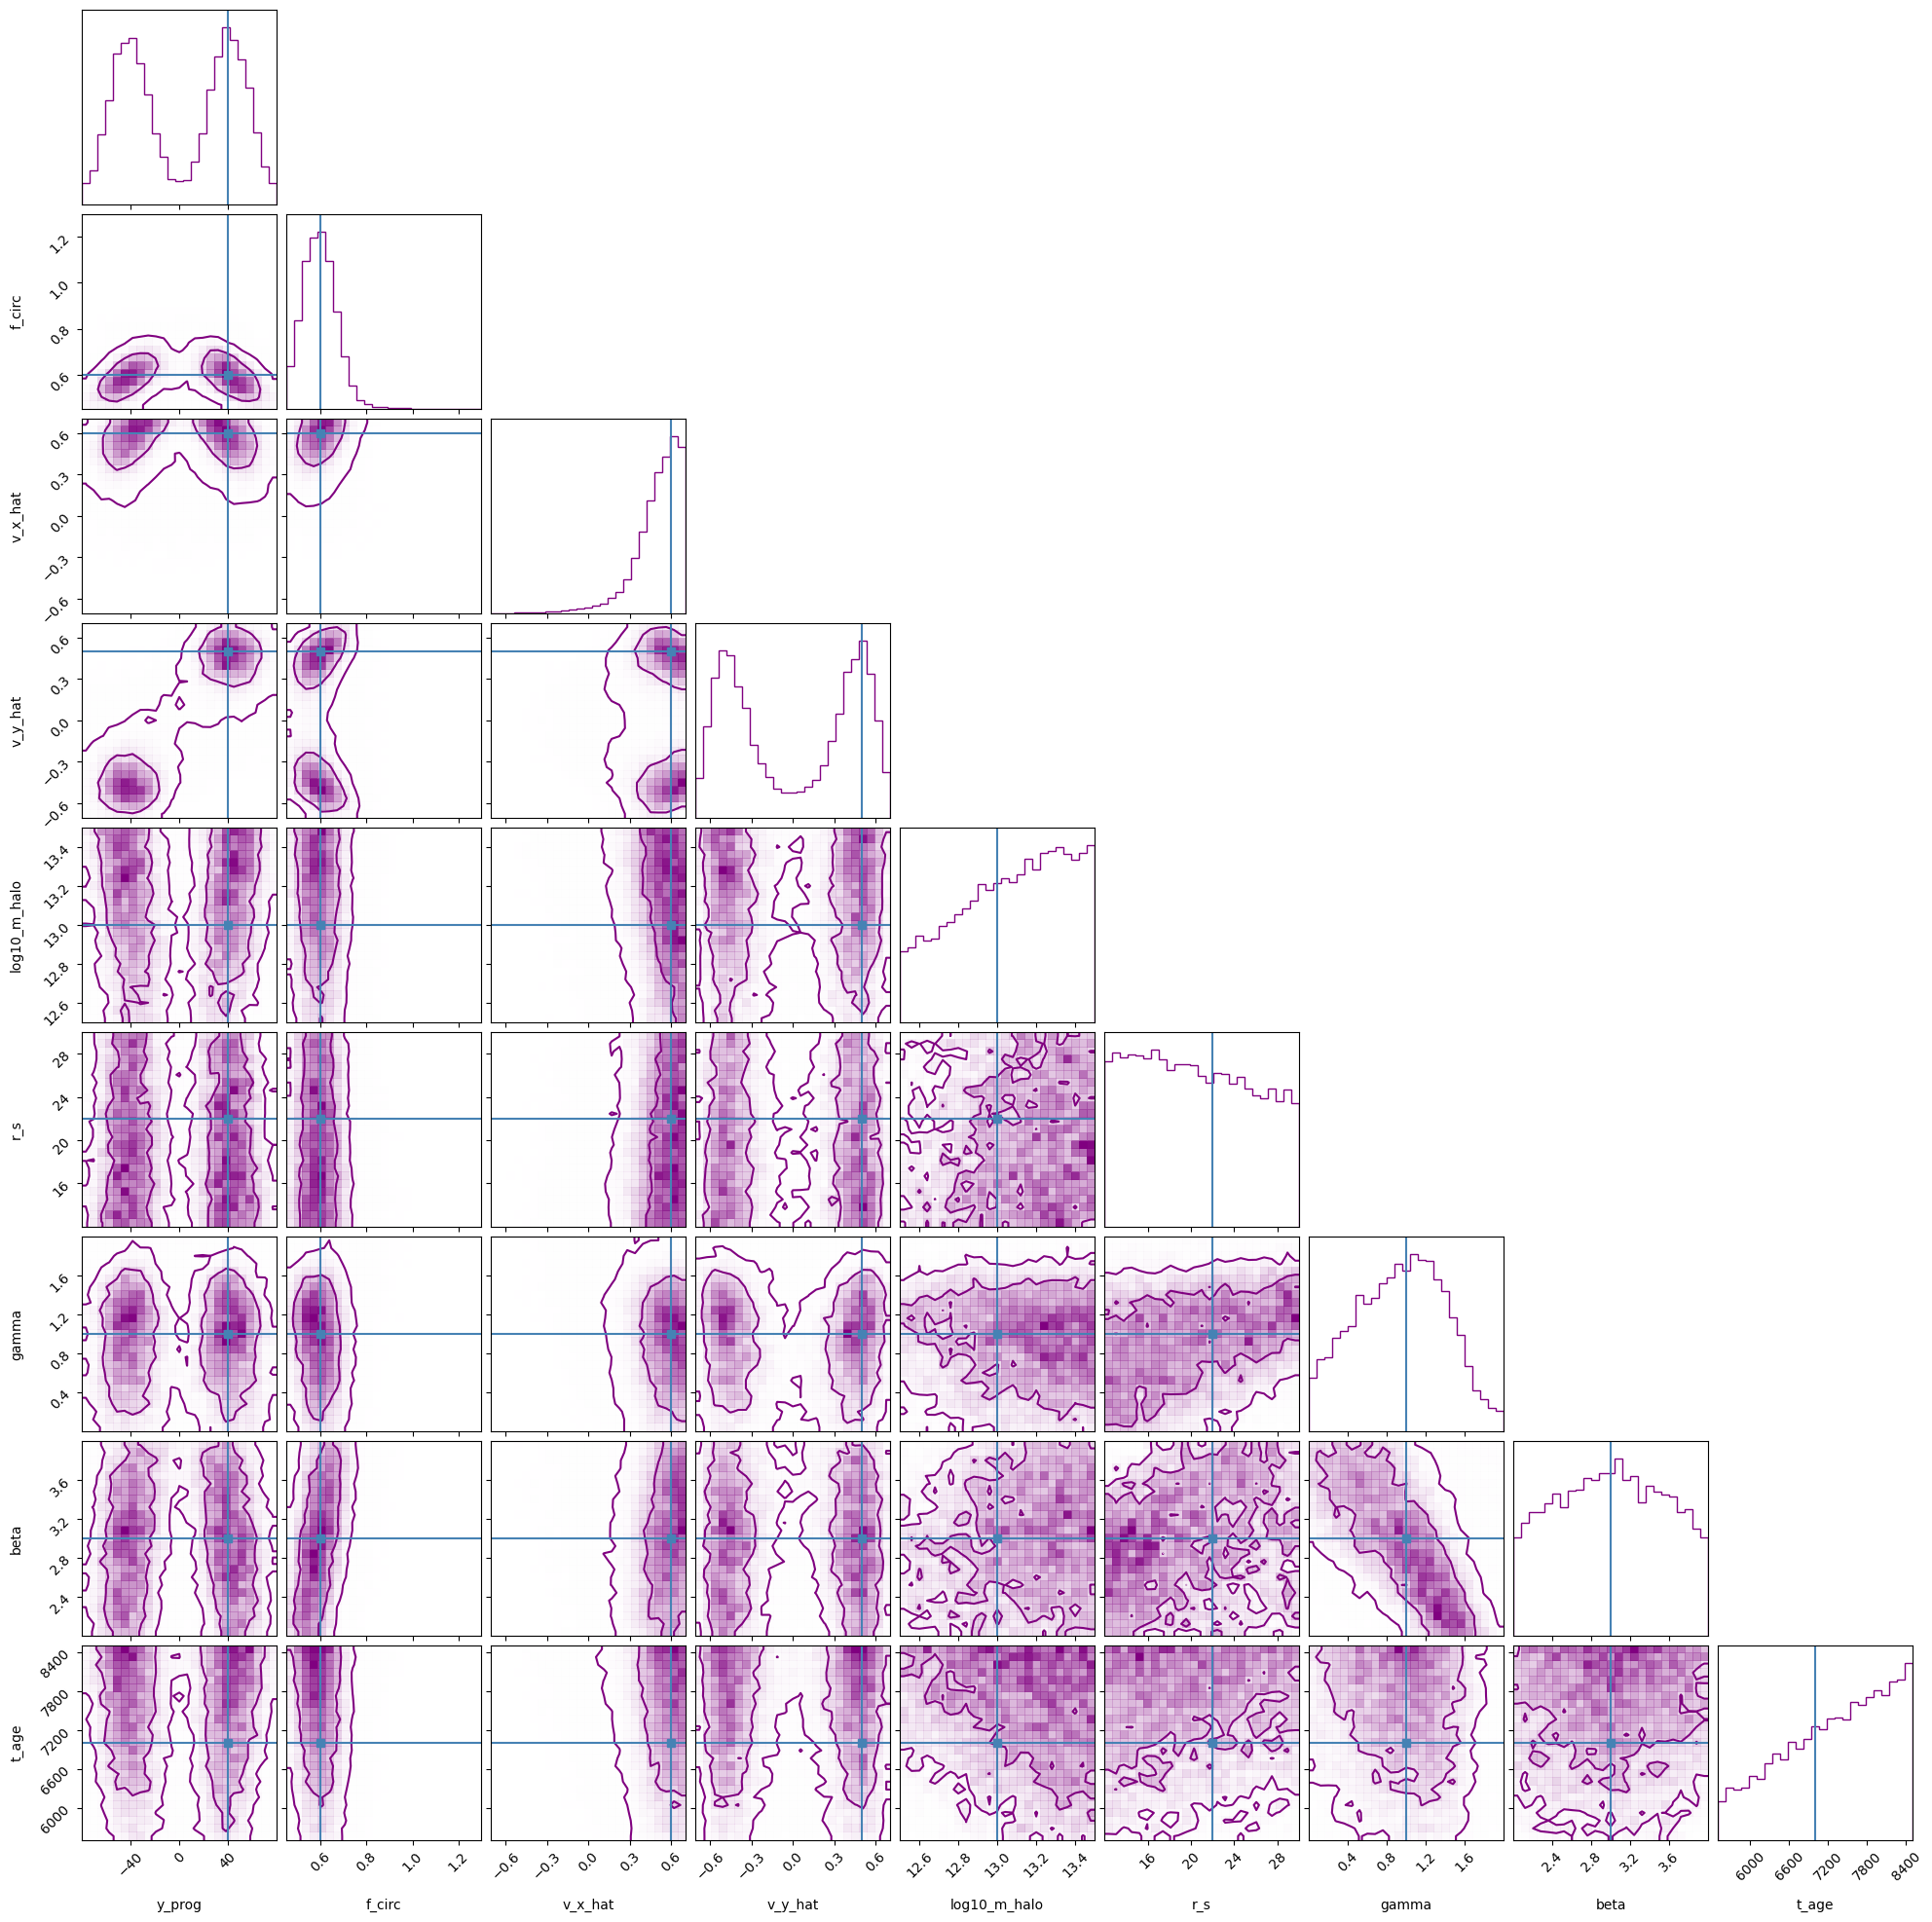

In [35]:
import corner
corner.corner(
    points, weights=np.exp(log_l-log_l.max()), bins=25, labels=prior.keys, color='purple',
    plot_datapoints=False, truths=true_params,levels=(0.67,0.95),
smooth=.5);

In [36]:
log_w.shape

(17500,)

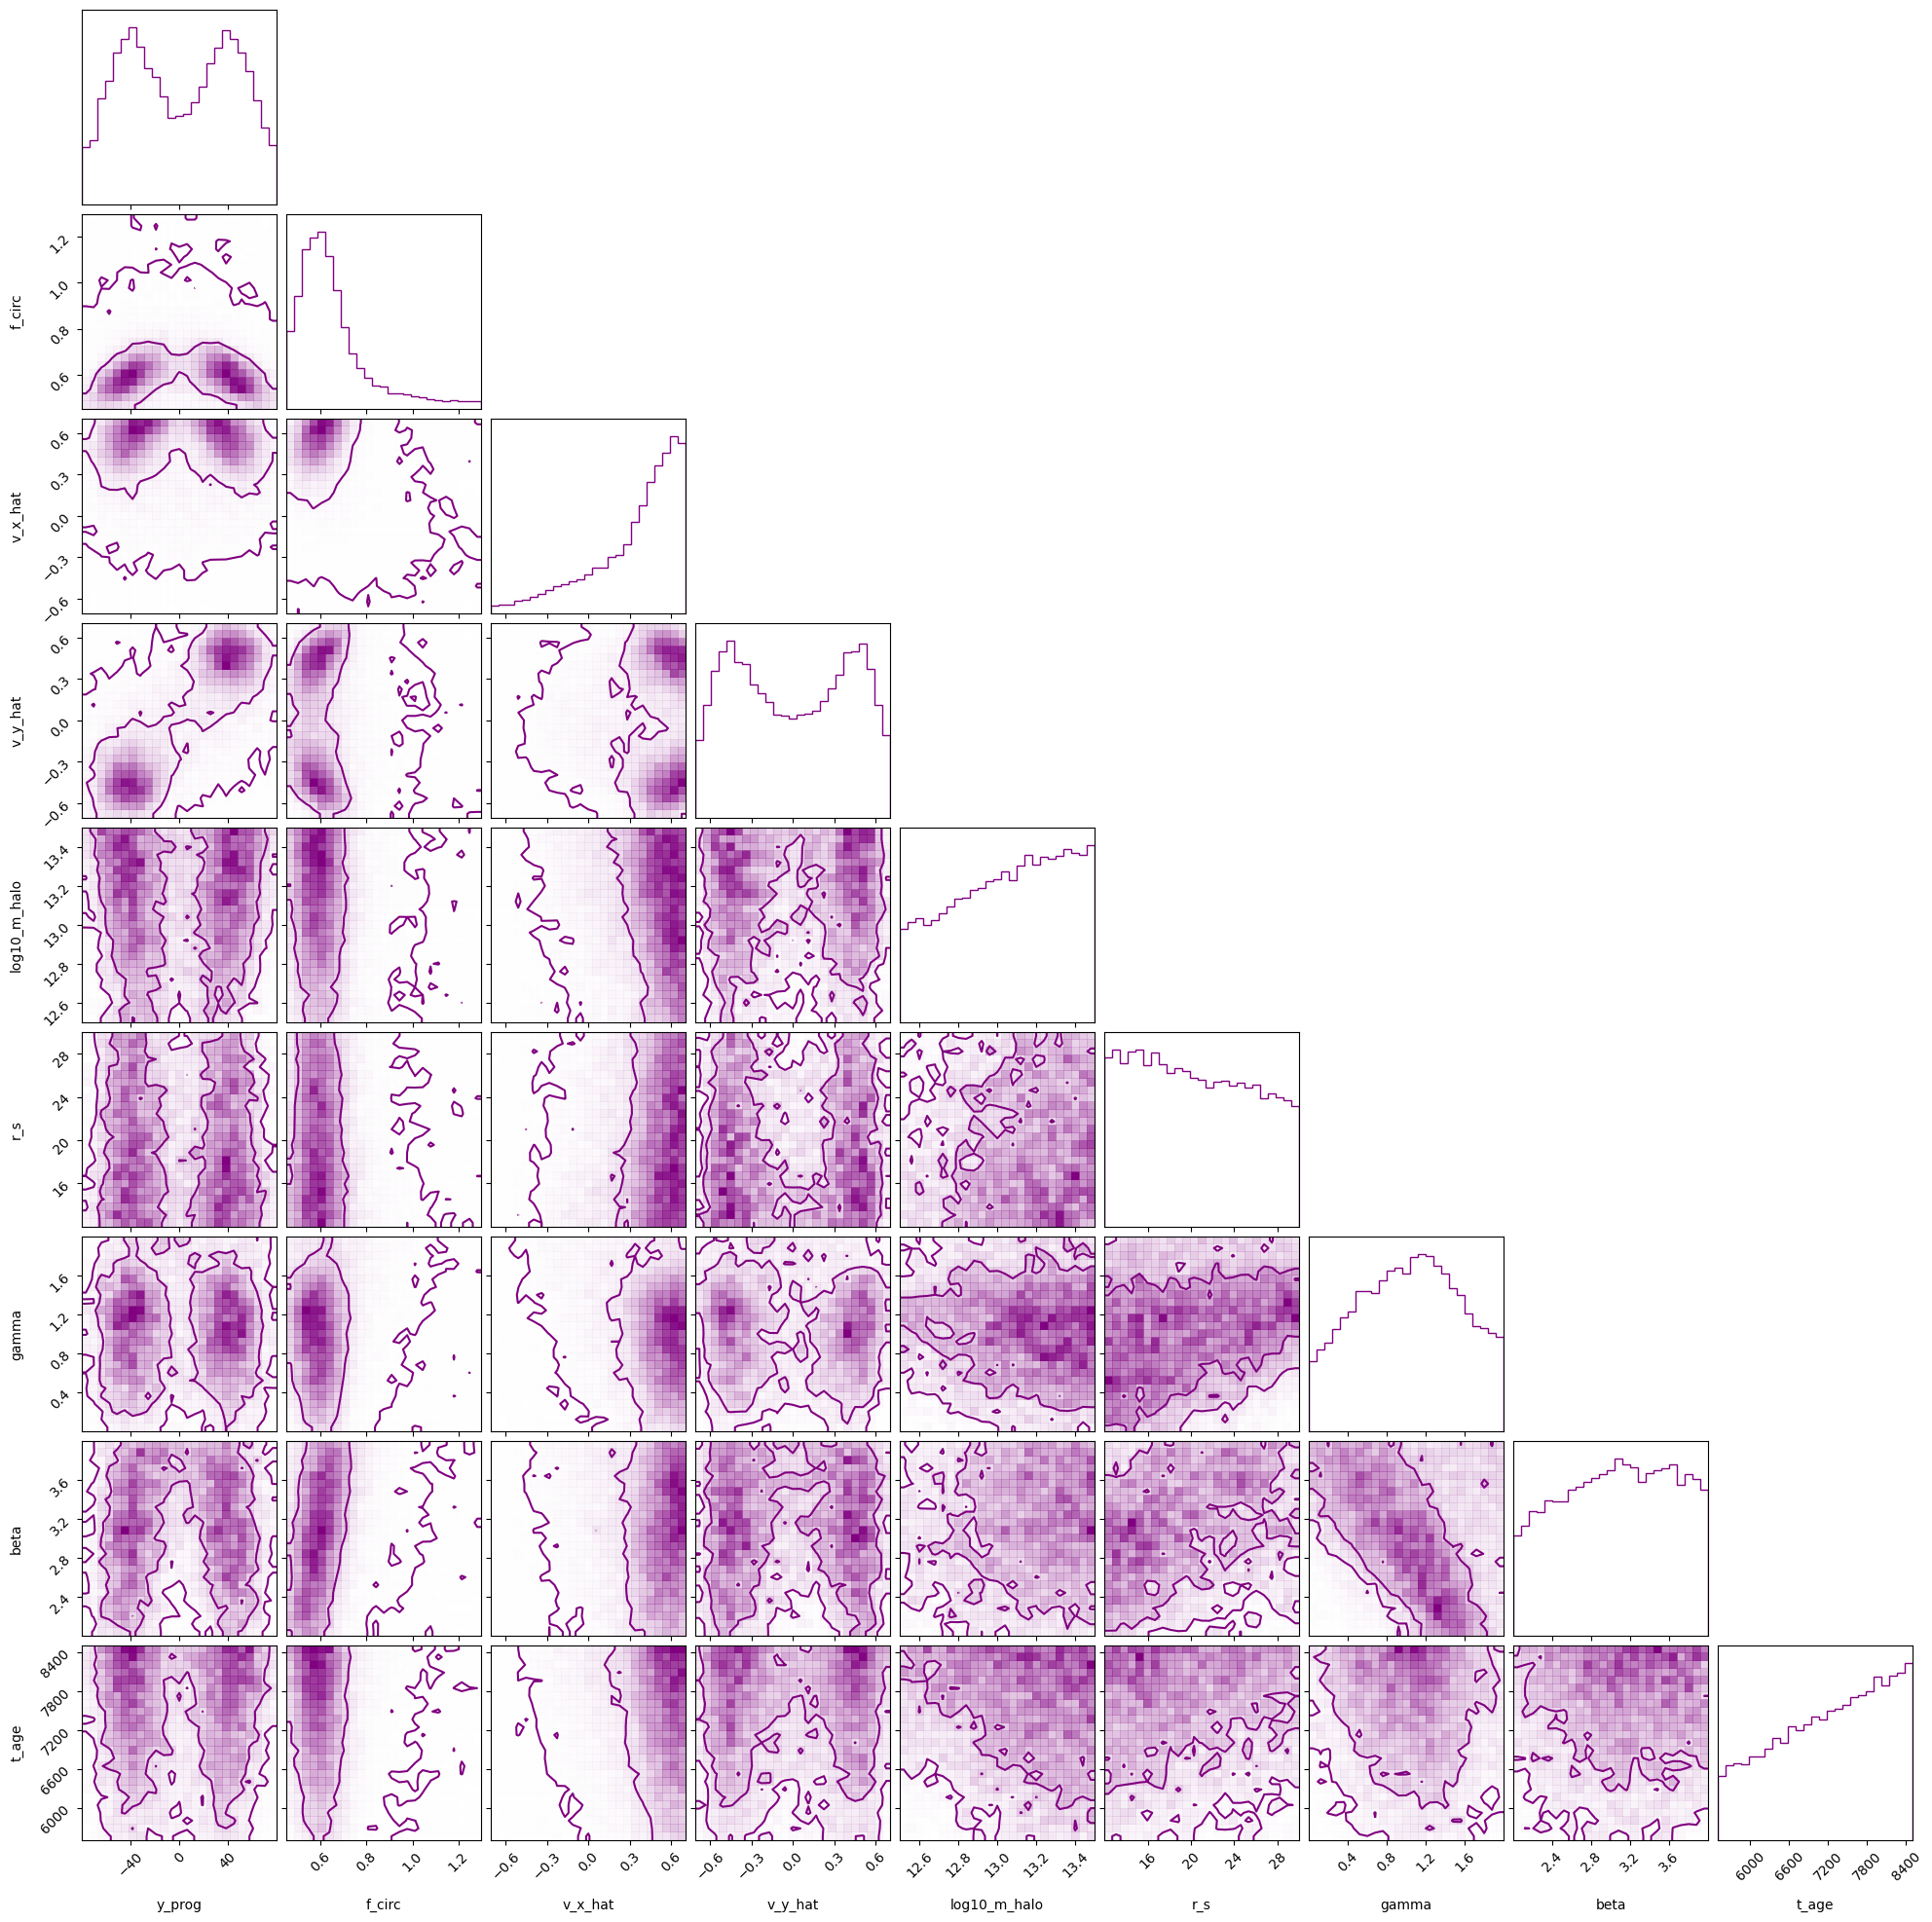

In [37]:
import corner
corner.corner(
    points, bins=25, labels=prior.keys, color='purple',
    plot_datapoints=False,truths=None,levels=(0.67,0.95),
smooth=.5);

In [ ]:
## Idea: fit kde to model stream and then evaluate probability of each point.
## Resample the points according to something like their inverse probability to remove density
## Refit the kde.